In [76]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string
import itertools
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds
- DJIA - Dow Jones Industrial Average

The analysis period is from 2000 to 2024

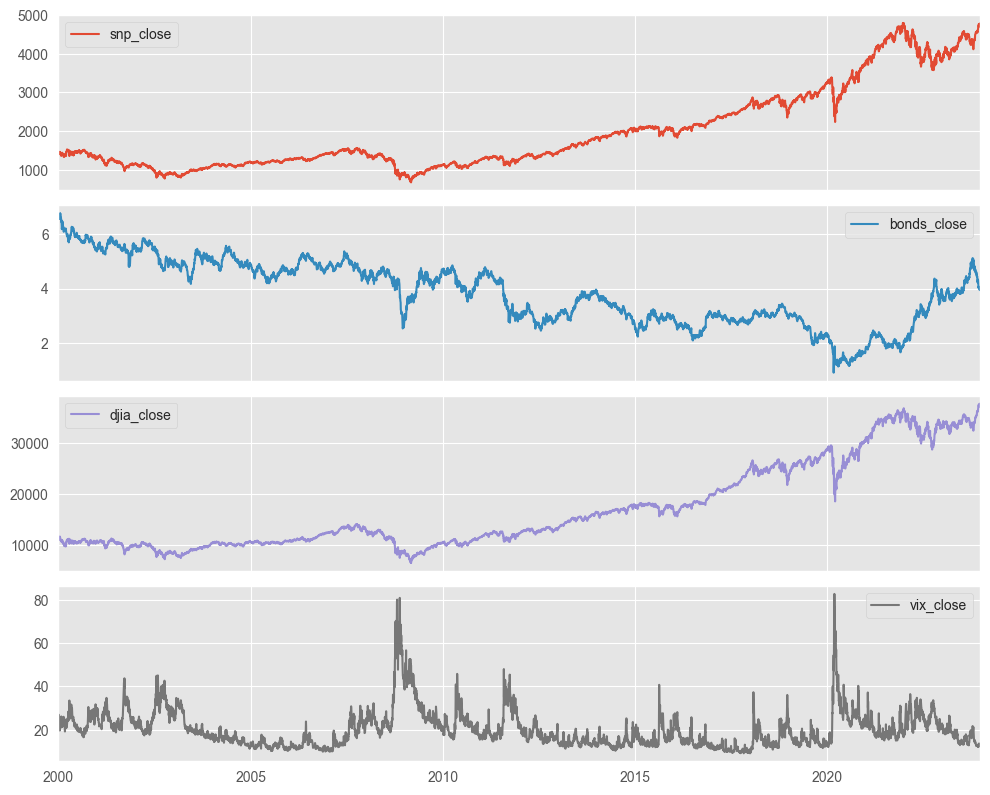

In [30]:
start_date = None
end_date = None

snp_data = pd.read_csv('assets/snp_data_clean.csv', index_col=0, parse_dates=True).add_prefix('snp_')[
           start_date:end_date]
bonds_data = pd.read_csv('assets/bonds_data_clean.csv', index_col=0, parse_dates=True).add_prefix('bonds_')[
             start_date:end_date]
djia_data = pd.read_csv('assets/djia_data_clean.csv', index_col=0, parse_dates=True).add_prefix('djia_')[
            start_date:end_date]
vix_data = pd.read_csv('assets/vix_data_clean.csv', index_col=0, parse_dates=True).add_prefix('vix_')[
           start_date:end_date]

merged_data = pd.concat(
    [snp_data['snp_close'], bonds_data['bonds_close'], djia_data['djia_close'], vix_data['vix_close']], axis=1)

merged_data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

### Scale data

In [203]:
anom_start_date = start_date
anom_end_date = '2022-01-01'

anomaly_data = merged_data[anom_start_date:anom_end_date]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(anomaly_data)
scaled_data = pd.DataFrame(scaled_data, columns=anomaly_data.columns, index=anomaly_data.index)

scaled_data.head()

,snp_close,bonds_close,djia_close,vix_close
2000-01-03,-0.369875,2.271738,-0.600222,0.489236
2000-01-04,-0.434952,2.217102,-0.651878,0.809479
2000-01-05,-0.431815,2.299056,-0.633961,0.740856
2000-01-06,-0.430252,2.250215,-0.615198,0.663082
2000-01-07,-0.385911,2.221241,-0.576512,0.204450


### Anomaly detection and removal with KNN

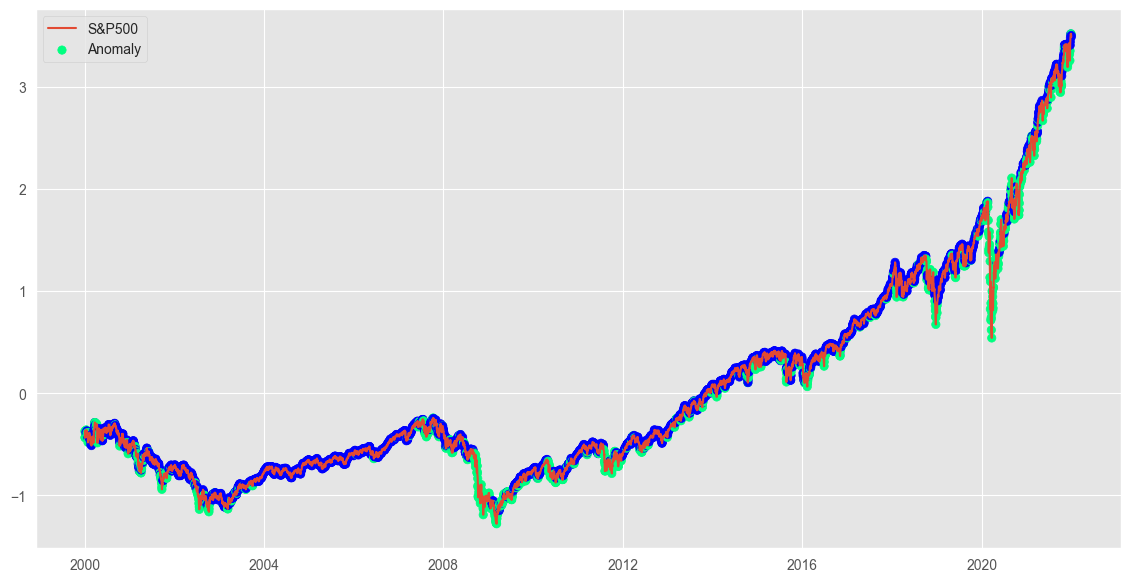

In [204]:
clf = KNN(contamination=0.2)

clf.fit(scaled_data)

y_pred = clf.labels_  # 0 for inliers, 1 for outliers
outlier_scores = clf.decision_scores_

scaled_data['anomaly'] = y_pred

scaled_data.head()

plt.figure(figsize=(14, 7))
plt.plot(scaled_data.index, scaled_data['snp_close'], label='S&P500')
plt.scatter(scaled_data.index, scaled_data['snp_close'], c=y_pred, cmap='winter', label='Anomaly')
plt.legend()
plt.show()

In [205]:
# Cut original data to match the anomaly data
merged_data_comparison = merged_data[anom_start_date:anom_end_date]

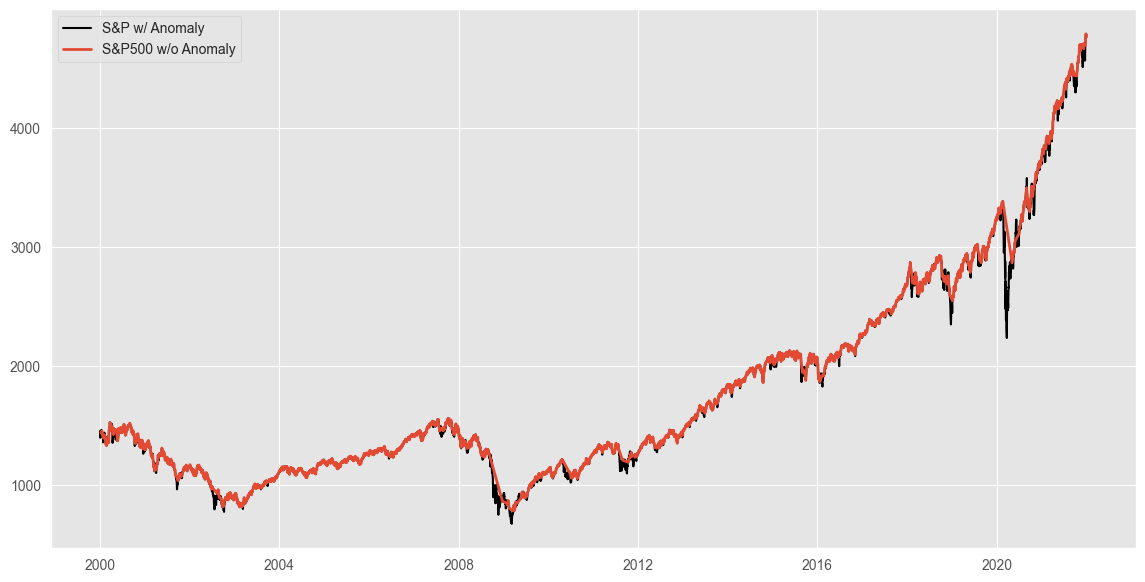

In [206]:
cleaned_data = scaled_data[scaled_data['anomaly'] == 0].drop(columns=['anomaly'])

# important, scale the cleaned data back, so it can be compared to original data
clean_scaled_data = scaler.inverse_transform(cleaned_data)

clean_scaled_data = pd.DataFrame(clean_scaled_data, columns=cleaned_data.columns, index=cleaned_data.index)

plt.figure(figsize=(14, 7))
plt.plot(merged_data_comparison.index,
         merged_data_comparison['snp_close'], label='S&P w/ Anomaly', color='black')
plt.plot(clean_scaled_data.index, clean_scaled_data['snp_close'], label='S&P500 w/o Anomaly', linewidth=2)
plt.legend()
plt.show()

### Statistical analysis of KNN anomaly detection
#### 1. Table comparison

In [207]:
def calculate_statistics(data, column):
    mean = data[column].mean()
    std_dev = data[column].std()
    skewness = skew(data[column])
    kurt = kurtosis(data[column])
    return mean, std_dev, skewness, kurt

original_stats = calculate_statistics(merged_data_comparison, 'snp_close')
cleaned_stats = calculate_statistics(clean_scaled_data, 'snp_close')

stats_comparison = pd.DataFrame({
    'Metric': ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'],
    'Original': original_stats,
    'Cleaned': cleaned_stats
})

stats_comparison

,Metric,Original,Cleaned
0,Mean,1772.368394,1750.316790
1,Standard Deviation,857.521653,800.359700
2,Skewness,1.403045,1.533620
3,Kurtosis,1.466674,2.126617


### Statistical analysis of KNN anomaly detection
#### 2. Graphical comparison
##### Distribution + KDE (Kernel Density Estimation)

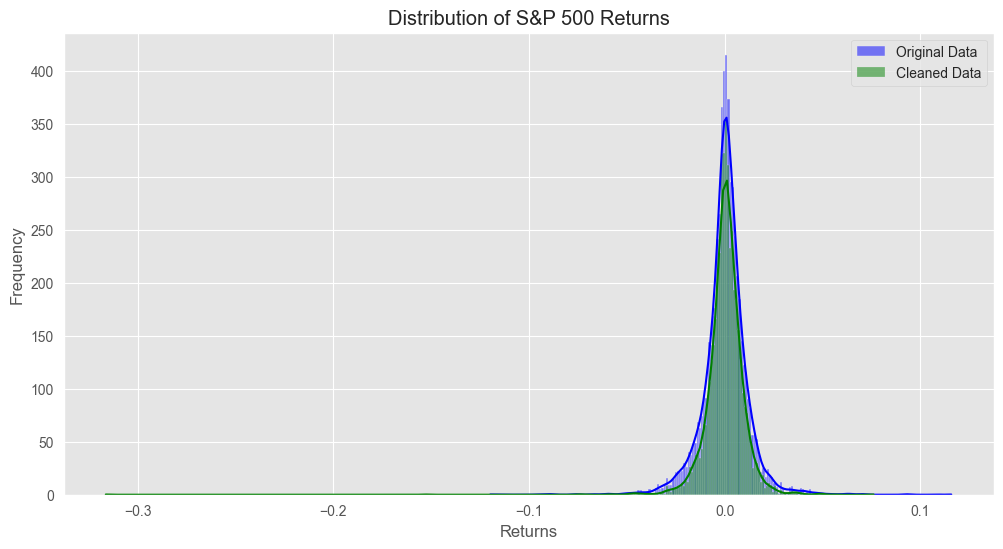

In [208]:
plt.figure(figsize=(12, 6))

original_returns = merged_data_comparison['snp_close'].pct_change().dropna()
cleaned_returns = clean_scaled_data['snp_close'].pct_change().dropna()

sns.histplot(original_returns, color='blue', label='Original Data', kde=True)
sns.histplot(cleaned_returns, color='green', label='Cleaned Data', kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Polynomial Regression and Forecasting

In [209]:
X = cleaned_data[['djia_close', 'bonds_close', 'vix_close']]
y = cleaned_data['snp_close']

# Create polynomial features (combinations)
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

y_pred = model.predict(X_poly)

In [210]:
mse = mean_squared_error(y, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.006780283220685192


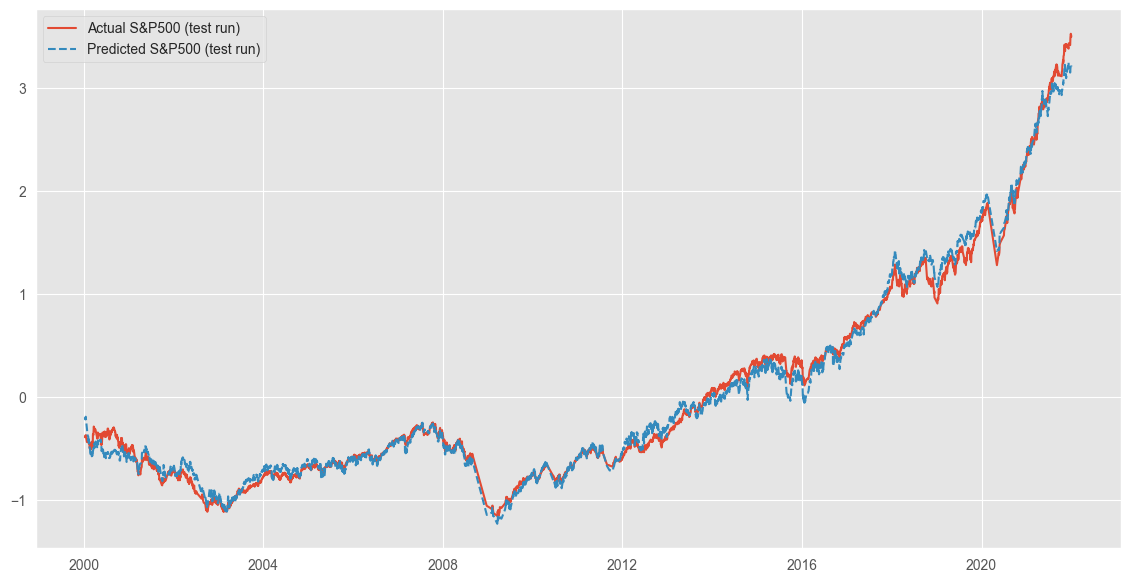

In [211]:
plt.figure(figsize=(14, 7))
plt.plot(cleaned_data.index, y, label='Actual S&P500 (test run)')
plt.plot(cleaned_data.index, y_pred, label='Predicted S&P500 (test run)', linestyle='--')
plt.legend()
plt.show()

### Forecasting

In [212]:
forecast_start_date = anom_end_date
forecast_end_date = '2022-06-01'

scaled_forecast_og_data = scaler.transform(merged_data)
scaled_forecast_og_data = pd.DataFrame(scaled_forecast_og_data, columns=merged_data.columns, index=merged_data.index)

future_X = scaled_forecast_og_data[forecast_start_date:forecast_end_date][['djia_close', 'bonds_close', 'vix_close']]

degree = 2
forecast_poly = PolynomialFeatures(degree)
future_X_poly = forecast_poly.fit_transform(future_X)

y_pred = model.predict(future_X_poly)

In [213]:
mse = mean_squared_error(scaled_forecast_og_data[forecast_start_date:forecast_end_date]['snp_close'], y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.05912495409187923


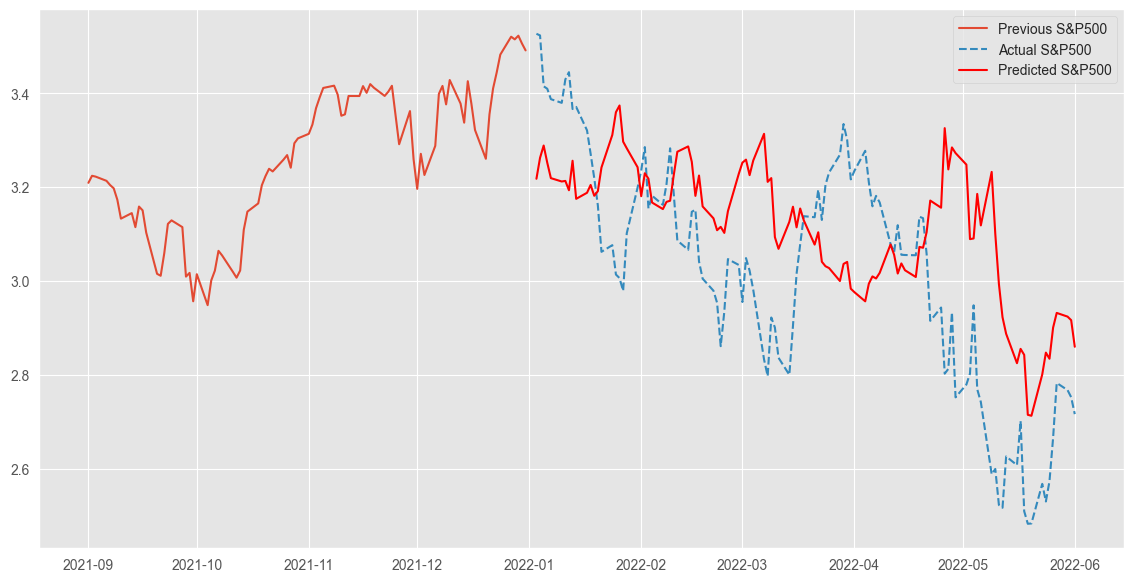

In [223]:
og_backfill_start = '2021-09-01'
og_backfill_data = scaled_forecast_og_data[og_backfill_start:forecast_start_date]['snp_close']
og_comparison_data = scaled_forecast_og_data[forecast_start_date:forecast_end_date]['snp_close']

plt.figure(figsize=(14, 7))
plt.plot(og_backfill_data.index, og_backfill_data, label='Previous S&P500')
plt.plot(og_comparison_data.index, og_comparison_data, label='Actual S&P500', linestyle='--')
plt.plot(future_X.index, y_pred, label='Predicted S&P500', color='red')
plt.legend()
plt.show()

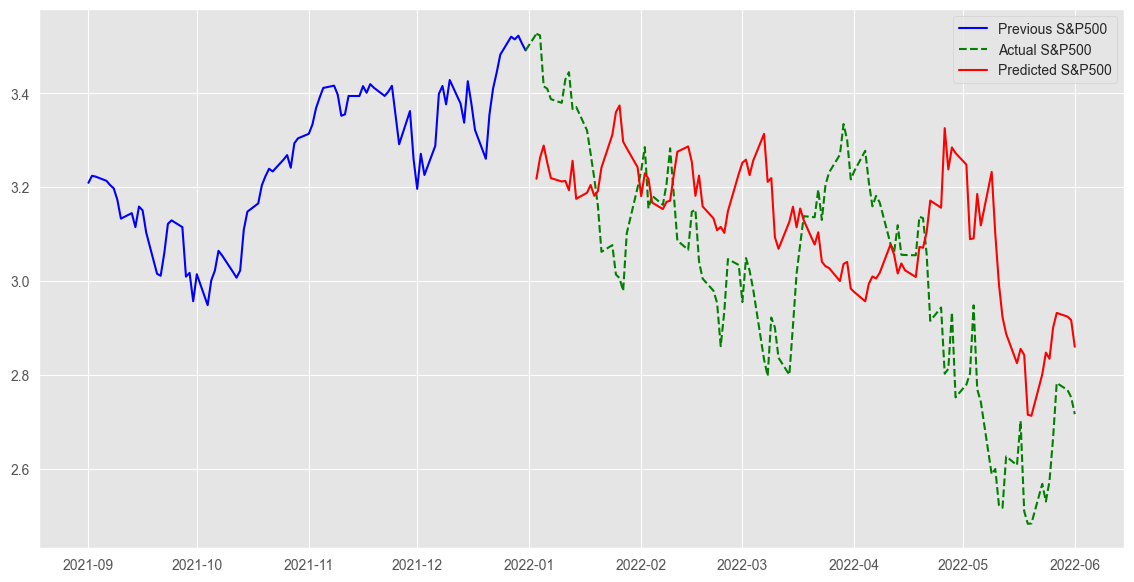

In [239]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine both series into a single DataFrame
combined_data = pd.concat([og_backfill_data, og_comparison_data])

# Ensure the index is continuous by reindexing
full_index = pd.date_range(start=og_backfill_data.index.min(), end=og_comparison_data.index.max(), freq='B')
combined_data = combined_data.reindex(full_index).ffill()

# Define the forecast start date as a variable
forecast_start_date = anom_end_date

# Split the combined data into two parts for coloring
combined_backfill_data = combined_data[:forecast_start_date]
combined_comparison_data = combined_data[forecast_start_date:]

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(combined_backfill_data.index, combined_backfill_data, label='Previous S&P500', color='blue')
plt.plot(combined_comparison_data.index, combined_comparison_data, label='Actual S&P500', linestyle='--', color='green')
plt.plot(future_X.index, y_pred, label='Predicted S&P500', color='red')

# Ensuring there are no gaps at the transition point
plt.plot([combined_backfill_data.index[-1], combined_comparison_data.index[0]], 
         [combined_backfill_data.iloc[-1], combined_comparison_data.iloc[0]], 
         color='green', linestyle='--')

plt.legend()
plt.show()
